In [127]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
import xrfdc #poorly documented library that handles interfacing to the RF data converter
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file
import pprint
pprint.pprint(ol.ip_dict)
dma_interfaces = [ol.axi_dma_0, ol.axi_dma_1, ol.axi_dma_2, ol.axi_dma_3] # 0 is ADC_D, 1 is ADC_C, 2 is ADC_B, 3 is ADC_A
rf = ol.usp_rf_data_converter_0

{'axi_dma_0': {'addr_range': 65536,
               'bdtype': None,
               'device': <pynq.pl_server.embedded_device.EmbeddedDevice object at 0xffffb4d06110>,
               'driver': <class 'pynq.lib.dma.DMA'>,
               'fullpath': 'axi_dma_0',
               'gpio': {},
               'interrupts': {},
               'mem_id': 'S_AXI_LITE',
               'memtype': 'REGISTER',
               'parameters': {'ADDR_WIDTH': '10',
                              'ARUSER_WIDTH': '0',
                              'AWUSER_WIDTH': '0',
                              'BUSER_WIDTH': '0',
                              'CLK_DOMAIN': 'design_1_zynq_ultra_ps_e_0_0_pl_clk0',
                              'C_BASEADDR': '0xA0000000',
                              'C_DLYTMR_RESOLUTION': '125',
                              'C_ENABLE_MULTI_CHANNEL': '0',
                              'C_FAMILY': 'zynquplus',
                              'C_HIGHADDR': '0xA000FFFF',
                          

                                                                                                     '0x00, '
                                                                                                     '0x40, '
                                                                                                     '0x80, '
                                                                                                     'and '
                                                                                                     'so '
                                                                                                     'forth. '
                                                                                                     'Any '
                                                                                                     'other '
                                                                                                     'alignment '
            

                                             'description': 'S2MM DMA Transfer '
                                                            'Length Register',
                                             'fields': {'Length': {'access': 'read-write',
                                                                   'bit_offset': 0,
                                                                   'bit_width': 26,
                                                                   'description': 'Indicates '
                                                                                  'the '
                                                                                  'length '
                                                                                  'in '
                                                                                  'bytes '
                                                                                  'of '
                                      

                                                                                   'address. '
                                                                                   'This '
                                                                                   'error '
                                                                                   'condition '
                                                                                   'causes '
                                                                                   'the '
                                                                                   'AXI '
                                                                                   'DMA '
                                                                                   'to '
                                                                                   'halt '
                                                                                   

                                                                                  '(EOF) '
                                                                                  'bit '
                                                                                  'set. '
                                                                                  'When '
                                                                                  'set '
                                                                                  'to '
                                                                                  '1 '
                                                                                  'for '
                                                                                  'Direct '
                                                                                  'Register '
                                                                                  'Mode, '
          

                                            'mDAC_NCO_Freq01': '0.0',
                                            'mDAC_NCO_Freq02': '0.0',
                                            'mDAC_NCO_Freq03': '0.0',
                                            'mDAC_NCO_Phase00': '0',
                                            'mDAC_NCO_Phase01': '0',
                                            'mDAC_NCO_Phase02': '0',
                                            'mDAC_NCO_Phase03': '0',
                                            'mDAC_Neg_Quadrature00': 'false',
                                            'mDAC_Neg_Quadrature01': 'false',
                                            'mDAC_Neg_Quadrature02': 'false',
                                            'mDAC_Neg_Quadrature03': 'false',
                                            'mDAC_Nyquist00': '0',
                                            'mDAC_Nyquist01': '0',
                                            'mDAC_Nyquist02': '0',
 

                                      'PSU__USE__S_AXI_GP4': '0',
                                      'PSU__USE__S_AXI_GP5': '0',
                                      'PSU__USE__S_AXI_GP6': '0',
                                      'PSU__USE__USB3_0_HUB': '0',
                                      'PSU__USE__USB3_1_HUB': '0',
                                      'PSU__USE__VIDEO': '0',
                                      'PSU__VIDEO_REF_CLK__ENABLE': '0',
                                      'PSU__VIDEO_REF_CLK__FREQMHZ': '33.333',
                                      'PSU__VIDEO_REF_CLK__IO': '<Select>',
                                      'QSPI_BOARD_INTERFACE': 'custom',
                                      'READ_WRITE_MODE': 'READ_WRITE',
                                      'RUSER_BITS_PER_BYTE': '0',
                                      'RUSER_WIDTH': '0',
                                      'SATA_BOARD_INTERFACE': 'custom',
                                      '

Hardware execution time:  0.0012803077697753906


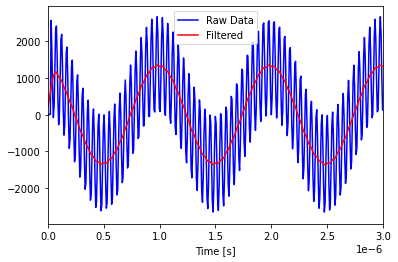

In [130]:
import time
import numpy as np
from pynq import allocate
import matplotlib.pyplot as plt
from scipy import signal

# Sampling frequency
fs = 147.456e6
# Number of samples
n = 65536
T = n/fs

"""
def plot_fft(samples,in_signal,n_samples):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Frequency')
    plt.grid()
    plt.plot(samples[:n_samples] - fs/2,in_signal[:n_samples],'y-',label='Signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Signal')
    plt.legend()
"""

ns = np.linspace(0, fs, n, endpoint = False)

out_buffer = allocate(400024, dtype=np.int32)
# Trigger the DMA transfer and wait for the result
start_time = time.time()
dma_interfaces[0].recvchannel.transfer(out_buffer)
dma_interfaces[0].recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware execution time: ',hw_exec_time)

real = []
imag = []
#extract the two values (I and Q) from each 32 bit write from the hardware side.
for i in range(65536):
    val = out_buffer[i]&0xFFFF
    if val>=32768:
        real.append(np.int32(0xFFFF0000|val))
    else:
        real.append(val)
    imag.append((out_buffer[i]>>16))

#c_data = np.array(real) + 1j*np.array(imag)
#z = np.fft.fftshift(np.fft.fft(c_data,n))
#plot_fft(ns,abs(z),65535)

plt.xlim(0, 3e-6)
plt.xlabel("Time [s]")
plt.plot(np.linspace(0, T, n), np.array(real), color = "blue", label = "Raw Data")

fir_filter = signal.firwin(15, [1e6 - 5e3, 1e6 + 5e3], fs = fs, pass_zero = False)
real_filtered = signal.convolve(np.array(real), fir_filter, mode = "same")

plt.plot(np.linspace(0, T, n), real_filtered, color = "red", label = "Filtered")

plt.legend()

out_buffer.close()